# Intersects tests

In [ ]:
import pystare
import geopandas
import starepandas
import datetime
import matplotlib.pyplot as plt
import dask
from shapely.wkt import loads

In [ ]:
# Load Country
#countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
countries = {
    'pop_est': [361313.0, 211049527.0],
    'continent': ['Europe', 'South America'],
    'name': ['Iceland', 'Brazil'],
    'iso_a3': ['ISL', 'BRA'],
    'gdp_md_est': [24188, 1839758],
    'geometry': [
        # Iceland geometry
        "POLYGON ((-14.50869544112923 66.45589223903143, -14.73963741704161 65.8087482774403, -13.60973222497981 65.12667104761987, -14.9098337467949 64.36408193628868, -17.79443803554342 63.67874909123385, -18.65624589687499 63.49638296167582, -19.97275468594276 63.64363495549153, -22.76297197111016 63.96017894149539, -21.77848425951768 64.40211579045551, -23.95504391121911 64.8911298692335, -22.18440263517036 65.08496816676031, -22.22742326505333 65.37859365504274, -24.32618404793934 65.61118927678847, -23.65051469572309 66.26251902939522, -22.13492245125089 66.41046865504687, -20.57628373867955 65.73211212835143, -19.05684160000159 66.27660085719477, -17.79862382655905 65.99385325790978, -16.16781897629212 66.52679230413587, -14.50869544112923 66.45589223903143))",
        # Brazil geometry
        "POLYGON ((-53.37366166849824 -33.76837778090076, -53.6505439927181 -33.20200408298183, -53.20958899597154 -32.72766611097472, -53.78795162618219 -32.04724252698762, -54.57245154480512 -31.49451140719375, -55.60151017924935 -30.85387867607139, -55.97324459494094 -30.8830758603163, -56.97602576356473 -30.10968637463613, -57.62513342958296 -30.21629485445426, -56.29089962423908 -28.85276051200089, -55.16228634298457 -27.88191537853346, -54.49072526713552 -27.47475676850579, -53.64873531758789 -26.92347258881609, -53.62834896504874 -26.12486500417747, -54.13004960795439 -25.54763925547725, -54.62529069682358 -25.73925546641551, -54.42894609233059 -25.16218474701217, -54.29347632507745 -24.57079965586396, -54.29295956075452 -24.02101409271073, -54.65283423523513 -23.83957813893396, -55.02790178080955 -24.00127369557523, -55.40074723979542 -23.9569353166688, -55.51763932963964 -23.57199757252664, -55.61068274598114 -22.65561939869485, -55.79795813660691 -22.35692962004782, -56.47331743022939 -22.08630014413528, -56.8815095689029 -22.28215382252148, -57.93715572776129 -22.09017587655717, -57.8706739976178 -20.73268767668195, -58.16639238140804 -20.17670094165368, -57.85380164247451 -19.96999521248619, -57.94999732118583 -19.40000416430682, -57.67600887717431 -18.96183969490403, -57.49837114117099 -18.17418751391129, -57.734558274961 -17.55246835700777, -58.28080400250225 -17.27171030036602, -58.38805843772404 -16.87710906338528, -58.24121985536668 -16.29957325609129, -60.15838965517904 -16.25828378669009, -60.54296566429515 -15.0939104142896, -60.25114885114294 -15.07721892665932, -60.26432634137737 -14.64597909918364, -60.45919816755003 -14.35400725673455, -60.50330400251114 -13.77595468511766, -61.08412126325565 -13.4793836401946, -61.71320431176078 -13.48920216233005, -62.12708085798639 -13.19878061284972, -62.80306026879639 -13.00065317144269, -63.19649878605057 -12.62703256597243, -64.3163529120316 -12.46197804123219, -65.40228146021303 -11.56627044031715, -65.32189876978302 -10.89587208419468, -65.44483700220539 -10.51145110437543, -65.33843522811642 -9.761987806846392, -66.64690833196281 -9.931331475466862, -67.17380123561074 -10.30681243249961, -68.04819230820539 -10.71205901453249, -68.27125362819326 -11.01452117273682, -68.78615759954948 -11.03638030359628, -69.52967810736496 -10.95173430750219, -70.09375220404689 -11.12397185633101, -70.54868567572841 -11.00914682377847, -70.48189388699117 -9.490118096558845, -71.30241227892154 -10.07943613041537, -72.18489071316985 -10.05359791426943, -72.56303300646564 -9.520193780152717, -73.22671342639016 -9.462212823121234, -73.01538265653255 -9.032833347208062, -73.57105933296707 -8.424446709835834, -73.98723548042966 -7.523829847853065, -73.7234014553635 -7.340998630404414, -73.72448666044164 -6.91859547285064, -73.1200274319236 -6.629930922068239, -73.21971126981461 -6.089188734566078, -72.9645072089412 -5.741251315944893, -72.89192765978726 -5.274561455916981, -71.74840572781655 -4.593982842633011, -70.92884334988358 -4.401591485210368, -70.7947688463023 -4.251264743673303, -69.89363521999663 -4.298186944194327, -69.44410193548961 -1.556287123219818, -69.42048580593223 -1.122618503426409, -69.5770653957766 -0.549991957200163, -70.02065589057005 -0.1851563452195393, -70.01556576198931 0.5414142928042054, -69.45239600287246 0.7061587589506929, -69.25243404811906 0.6026508650700748, -69.21863766140018 0.9856765812174331, -69.80459672715773 1.089081122233466, -69.81697323269162 1.714805202639624, -67.86856502955884 1.692455145673392, -67.5378100246747 2.03716278727633, -67.25999752467359 1.719998684084956, -67.0650481838525 1.130112209473225, -66.87632585312258 1.253360500489336, -66.32576514348496 0.7244522159820121, -65.54826738143757 0.7892544620760303, -65.35471330428837 1.0952822941085, -64.61101192895987 1.328730576987042, -64.19930579289051 1.49285492594602, -64.08308549666609 1.91636912679408, -63.36878801131166 2.200899562993129, -63.42286739770512 2.411067613124175, -64.2699991522658 2.497005520025567, -64.40882788761792 3.126786200366624, -64.36849443221411 3.797210394705246, -64.81606401229402 4.056445217297423, -64.62865943058755 4.14848094320925, -63.88834286157416 4.020530096854571, -63.09319759789911 3.770571193858785, -62.80453304711671 4.006965033377952, -62.08542965355913 4.162123521334308, -60.96689327660154 4.536467596856639, -60.60117916527194 4.91809804933213, -60.73357418480372 5.200277207861901, -60.21368343773133 5.244486395687602, -59.98095862490489 5.014061184098139, -60.11100236676738 4.574966538914083, -59.76740576845872 4.423502915866607, -59.53803992373123 3.958802598481938, -59.81541317405787 3.606498521332085, -59.97452490908456 2.755232652188056, -59.71854570172675 2.24963043864436, -59.64604366722126 1.786893825686789, -59.03086157900265 1.317697658692722, -58.5400129868783 1.268088283692521, -58.42947709820596 1.463941962078721, -58.11344987652502 1.507195135907025, -57.66097103537737 1.682584947105639, -57.3358229233969 1.948537705895759, -56.78270423036083 1.863710842288654, -56.53938574891455 1.899522609866921, -55.99569800477175 1.817667141116601, -55.90560014507088 2.02199575439866, -56.0733418442903 2.220794989425499, -55.97332210958938 2.510363877773017, -55.569755011606 2.421506252447131, -55.09758744975514 2.523748073736613, -54.52475419779972 2.311848863123785, -54.08806250671725 2.105556545414629, -53.77852067728892 2.376702785650082, -53.55483924011354 2.334896551925951, -53.41846513529531 2.053389187015981, -52.93965715189496 2.124857692875636, -52.55642473001842 2.504705308437053, -52.24933753112396 3.241094468596245, -51.65779741067889 4.156232408053029, -51.31714636901086 4.203490505383954, -51.06977128762966 3.650397650564031, -50.50887529153366 1.901563828942457, -49.97407589374506 1.736483465986069, -49.94710079608871 1.046189683431223, -50.69925126809692 0.2229841170216815, -50.38821082213214 -0.07844451253681939, -48.62056677915632 -0.2354891902718208, -48.58449662941659 -1.237805271005001, -47.82495642759064 -0.5816179337628, -46.56658362485123 -0.941027520352776, -44.90570309099041 -1.551739597178134, -44.41761918799367 -2.137750339367976, -44.58158850765578 -2.691308282078524, -43.41879126644019 -2.383110039889793, -41.47265682632825 -2.912018324397116, -39.97866533055404 -2.873054294449041, -38.50038347019657 -3.700652357603396, -37.2232521225352 -4.820945733258917, -36.45293738457639 -5.109403578312154, -35.59779578301047 -5.149504489770649, -35.23538896334756 -5.464937432480247, -34.89602983248683 -6.738193047719711, -34.72999345553303 -7.343220716992967, -35.12821204277422 -8.996401462442286, -35.63696651868771 -9.649281508017815, -37.046518724097 -11.0407211239088, -37.68361161960736 -12.17119475672582, -38.42387651218844 -13.03811858485429, -38.67388709161652 -13.05765227626062, -38.95327572280254 -13.79336964280002, -38.88229814304965 -15.66705372483877, -39.16109249526431 -17.20840667080847, -39.2673392400564 -17.86774627042048, -39.58352149103423 -18.26229583096894, -39.76082333022764 -19.59911345792741, -40.77474077001034 -20.90451181405242, -40.94475623225061 -21.93731698983781, -41.75416419123822 -22.37067555103746, -41.98828426773656 -22.9700704891909, -43.07470374202475 -22.96769337330547, -44.64781185563781 -23.35195932382784, -45.35213578955992 -23.79684172942858, -46.47209326840554 -24.08896860117454, -47.64897233742066 -24.88519906992772, -48.4954581365777 -25.87702483490565, -48.64100480812774 -26.62369760509093, -48.47473588722865 -27.17591196056189, -48.66152035174763 -28.18613453543572, -48.8884574041574 -28.67411508556788, -49.58732947447267 -29.22446908947634, -50.69687415221149 -30.98446502047296, -51.57622616230616 -31.77769825615321, -52.25608130553805 -32.24536996839467, -52.71209998229769 -33.19657805759118, -53.37366166849824 -33.76837778090076))",
    ]
}
countries["geometry"] = [loads(wkt) for wkt in countries["geometry"]]
countries = geopandas.GeoDataFrame(countries, crs="EPSG:4326")
iceland = countries[countries.name=='Iceland']
sids = starepandas.sids_from_gdf(iceland, level=8, force_ccw=True)
iceland = starepandas.STAREDataFrame(iceland, sids=sids)

# Load Granule
#fname = starepandas.datasets.get_path('MOD05_L2.A2019336.0000.061.2019336211522.hdf')
fname = '../starepandas/datasets/MOD05_L2.A2019336.0000.061.2019336211522.hdf'
modis = starepandas.read_granule(fname, latlon=True, sidecar=True)
geom = geopandas.points_from_xy(modis.lon, modis.lat, crs='EPSG:4326')
modis.set_geometry(geom, inplace=True)

In [3]:
sum(modis.stare_intersects(sids.iloc[0]))

1384

In [4]:
# STARE based intersects
sids_iceland = iceland['sids'].iloc[0]
sids_modis = list(modis['sids'])

start = datetime.datetime.now()
intersects_stare = pystare.intersects(sids_iceland, sids_modis)
print(datetime.datetime.now() - start)

0:00:00.109635


In [5]:
# Conventional shapely based instersects test.

# pygeos integration is still fragile but may speed up things 
geopandas.options.use_pygeos = False

start = datetime.datetime.now()
intersects = modis.intersects(iceland.geometry.iloc[0])
print(datetime.datetime.now() - start)

0:00:00.243387


In [6]:
iceland.set_trixels(iceland.make_trixels(),inplace=True)

In [7]:
# iceland.make_trixels()

In [8]:
iceland.trixels

144    MULTIPOLYGON (((-17.47089 63.57653, -16.74124 ...
Name: trixels, dtype: geometry

In [9]:
start = datetime.datetime.now()
modis.set_trixels(modis.make_trixels(),inplace=True)
print(datetime.datetime.now() - start)

0:00:20.169792


In [10]:
# geom = geopandas.points_from_xy(modis.lon, modis.lat, crs='EPSG:4326')
# modis.set_geometry(geom, inplace=True)

<AxesSubplot:>

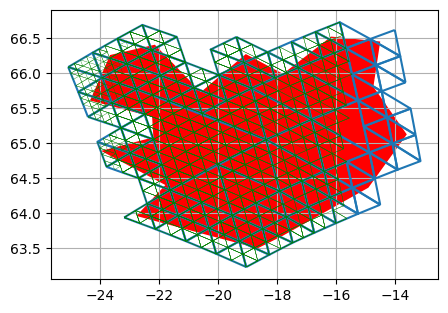

In [11]:
fig, ax = plt.subplots(figsize=(5,5), dpi=100)
ax.grid(True)

iceland.plot(ax=ax)
iceland.plot(ax=ax, trixels=False, boundary=True, linewidth=0.5, color='red')

modis[intersects_stare].plot(ax=ax, markersize=0.1, color='g', linewidth=0.25)

## Parallel

In [12]:
fname = 'VNP03DNB.A2020219.0742.001.2020219124651.nc'

n_workers = 50
sids_series = modis['sids']
ddf = dask.dataframe.from_pandas(sids_series, npartitions=n_workers)

In [13]:
meta = {'intersects': 'bool'}
res = ddf.map_partitions(lambda df: pystare.intersects(sids_iceland, df, 1), meta=meta)

In [14]:
a = res.compute(scheduler='processes')

In [15]:
len(a)

109620

In [16]:
intersects_stare = pystare.intersects(sids_iceland, sids_modis)

In [17]:
len(intersects_stare)

109620